# German Credit Risk

![credict risk](https://images.unsplash.com/photo-1553729459-efe14ef6055d?ixlib=rb-4.0.3&ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8&auto=format&fit=crop&w=800&q=80)

## Table of Contents
* [Introduction](#intro)
* [About the Data](#about_data)
* [Required Modules and Data](#required)
    * [Translating Encoded Feature Values](#translating)
    * [Feature Dictionary](#fdict)
    * [Data Integrity Check](#integrity)
* [Exploratory Data Analysis](#eda)
    * [Univariate Analysis](#univariate)
* [Classification](#classification)

## <a id="intro"></a>Introduction

Credit risk prediction is a critical process for financial institutions and lending organizations to evaluate the likelihood of potential borrowers defaulting on their loans. It is essential to identify and manage credit risk, as it has a significant impact on the financial performance and stability of these organizations. By accurately predicting credit risk, lenders can make informed decisions about whether to grant loans to applicants and determine appropriate interest rates. Additionally, credit risk prediction enables lenders to assess their overall risk exposure and develop strategies to mitigate it. With the increasing availability of data and the development of advanced analytics techniques, credit risk prediction has become more precise and efficient. As a result, it has become an integral part of credit risk management, helping financial institutions and lending organizations to make more informed decisions and minimize losses.

Within this context, this project aims to analyse data of loans from a german bank and build a predictive model capable of classify future credit takers in good or bad, so the bank can make an informed decision about credit approval/disapproval.

## <a id="about_data"></a>About the Data

The dataset used in this project is the [Statlog (German Credit Data) Data Set](https://archive.ics.uci.edu/ml/datasets/Statlog+%28German+Credit+Data%29) from UCI. It contains 20 attributes and 1000 instances and its values are encoded, so data translation will be necessary in the preprocessing step.

The dataset description is available in the following [link](https://archive.ics.uci.edu/ml/machine-learning-databases/statlog/german/german.doc).

## <a id="required"></a>Required Modules and Data

In [17]:
import math
import numpy as np
import pandas as pd
from pandas.api.types import is_numeric_dtype, is_categorical_dtype
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, OneHotEncoder
from sklearn.metrics import recall_score, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import lightgbm

import random

import warnings
warnings.filterwarnings("ignore")

seed = 42
random.seed(seed)
np.random.seed(seed)

sns.set_style(style="darkgrid")
sns.set_palette(palette="viridis")
sns.set(rc={
    'axes.facecolor': '#E0E0E0',
    'figure.facecolor': '#E0E0E0'
})

In [2]:
df = pd.read_csv(
    "https://archive.ics.uci.edu/ml/machine-learning-databases/statlog/german/german.data",
    delimiter=r"\s+",
    header=None
)

df.columns = [
    "status_checking_account",
    "duration",
    "credit_history",
    "purpose",
    "credit_amount",
    "savings",
    "employed_since",
    "pct_installment_rate",
    "personal_status_and_sex",
    "other_debtors_guarantors",
    "present_residence_since",
    "property",
    "age",
    "other_installment_plans",
    "housing",
    "existing_credits",
    "job",
    "maintenance_people",
    "telephone",
    "foreign_worker",
    "good_or_bad"
]

In [3]:
df.head()

,status_checking_account,duration,credit_history,purpose,credit_amount,savings,employed_since,pct_installment_rate,personal_status_and_sex,other_debtors_guarantors,...,property,age,other_installment_plans,housing,existing_credits,job,maintenance_people,telephone,foreign_worker,good_or_bad
0,A11,6,A34,A43,1169,A65,A75,4,A93,A101,...,A121,67,A143,A152,2,A173,1,A192,A201,1
1,A12,48,A32,A43,5951,A61,A73,2,A92,A101,...,A121,22,A143,A152,1,A173,1,A191,A201,2
2,A14,12,A34,A46,2096,A61,A74,2,A93,A101,...,A121,49,A143,A152,1,A172,2,A191,A201,1
3,A11,42,A32,A42,7882,A61,A74,2,A93,A103,...,A122,45,A143,A153,1,A173,2,A191,A201,1
4,A11,24,A33,A40,4870,A61,A73,3,A93,A101,...,A124,53,A143,A153,2,A173,2,A191,A201,2


As we can see, some features contains encoded values that need to be translated into meaningful values for our purposes.

### <a id="translating"></a>Translating Encoded Feature Values

In [4]:
def status_checking_account(df: pd.DataFrame):
    mapping = {
        "A14": "No Account",
        "A11": "< 0 DM",
        "A12": ">= 0 & < 200 DM",
        "A13": ">= 200 DM"
    }

    df["status_checking_account"] = df["status_checking_account"]. \
        map(mapping). \
        astype("category").cat.set_categories(list(mapping.values()), ordered=True)
    return df

def credit_history(df: pd.DataFrame):
    mapping = {
        "A30": "None Taken",
        "A31": "Paid Duly This Bank",
        "A32": "Paid Duly Existing",
        "A33": "Delayed in the Past",
        "A34": "Critical Account"
    }

    df["credit_history"] = df["credit_history"].map(mapping)
    return df

def purpose(df: pd.DataFrame):
    mapping = {
        "A40": "Car (new)",
        "A41": "Car (used)",
        "A42": "Furniture/Equipment",
        "A43": "Radio/TV",
        "A44": "Domestic Appliances",
        "A45": "Repairs",
        "A46": "Education",
        "A47": "Vacation",
        "A48": "Retraining",
        "A49": "Business",
        "A410": "Others"
    }

    df["purpose"] = df["purpose"].map(mapping)
    return df

def savings(df: pd.DataFrame):
    mapping = {
        "A65" : "No Account",
        "A61" : "< 100 DM",
        "A62" : ">= 100 DM & < 500 DM",
        "A63" : ">= 500 DM & < 1000 DM",
        "A64" : ">= 1000 DM"
    }

    df["savings"] = df["savings"]. \
        map(mapping). \
        astype("category").cat.set_categories(list(mapping.values()), ordered=True)
    return df

def employed_since(df: pd.DataFrame):
    mapping = {
        "A71" : "Unemployed",
        "A72" : "< 1 year",
        "A73" : ">= 1 year & < 4 years",
        "A74" : "4 years >= & < 7 years",
        "A75" : ">= 7 years"
    }

    df["employed_since"] = df["employed_since"]. \
        map(mapping). \
        astype("category").cat.set_categories(list(mapping.values()), ordered=True)
    return df

def personal_status_and_sex(df: pd.DataFrame):
    mapping = {
        "A91" : "Male - Divorced/Separated",
        "A92" : "Female - Divorced/Separated/Married",
        "A93" : "Male - Single",
        "A94" : "Male - Married/Widowed",
        "A95" : "Female - Single"
    }

    df["personal_status_and_sex"] = df["personal_status_and_sex"].map(mapping)
    return df

def other_debtors_guarantors(df: pd.DataFrame):
    mapping = {
        "A101" : "None",
        "A102" : "Co-applicant",
        "A103" : "Guarantor"
    }

    df["other_debtors_guarantors"] = df["other_debtors_guarantors"].map(mapping)
    return df

def property(df: pd.DataFrame):
    mapping = {
        "A121" : "Real Estate",
        "A122" : "Life Insurance",
        "A123" : "Car or Other",
        "A124" : "No Property"
    }

    df["property"] = df["property"].map(mapping)
    return df

def other_installment_plans(df: pd.DataFrame):
    mapping = {
        "A141": "Bank",
        "A142": "Stores",
        "A143": "None"
    }

    df["other_installment_plans"] = df["other_installment_plans"].map(mapping)
    return df

def housing(df: pd.DataFrame):
    mapping = {
        "A151": "Rent",
        "A152": "Own",
        "A153": "For Free"
    }

    df["housing"] = df["housing"].map(mapping)
    return df

def job(df: pd.DataFrame):
    mapping = {
        "A171": "Unskilled",
        "A172": "Resident",
        "A173": "Skilled",
        "A174": "Highly Skilled"
    }

    df["job"] = df["job"].map(mapping)
    return df

def telephone(df: pd.DataFrame):
    mapping = {
        "A191": "None",
        "A192": "Registered"
    }

    df["telephone"] = df["telephone"].map(mapping)
    return df

def foreign_worker(df: pd.DataFrame):
    mapping = {
        "A201": "Yes",
        "A202": "No"
    }

    df["foreign_worker"] = df["foreign_worker"].map(mapping)
    return df

def good_or_bad(df: pd.DataFrame):
    mapping = {
        1: "Good",
        2: "Bad"
    }

    df["good_or_bad"] = df["good_or_bad"].map(mapping)
    return df

In [5]:
%%capture

# wraping everything up with Pandas pipes

df.pipe(status_checking_account). \
    pipe(credit_history). \
    pipe(purpose). \
    pipe(savings). \
    pipe(employed_since). \
    pipe(personal_status_and_sex). \
    pipe(other_debtors_guarantors). \
    pipe(property). \
    pipe(other_installment_plans). \
    pipe(housing). \
    pipe(job). \
    pipe(telephone). \
    pipe(foreign_worker). \
    pipe(good_or_bad)

### <a id="fdict"></a>Feature Dictionary

* **status_checking_account**: Status of existing checking account.
* **duration**:  Duration in months.
* **credit_history**: Credit history.
* **purpose**: Purpose of the loan.
* **credit_amount**: Credit amount.
* **savings**: Saving account/bonds.
* **employed_since**: Present employment duration.
* **pct_installment_rate**: Installment rate in percentage of disposable income.
* **personal_status_and_sex**: Personal status and sex.
* **other_debtors_guarantors**: Other debtors /guarantors.
* **present_residence_since**: Present residence since.
* **property**: Property.
* **age**: Age.
* **other_installment_plans**: Other installment plans.
* **housing**: Housing status.
* **existing_credits**: Number of existing credits at this bank.
* **job**: Job skills.
* **maintenance_people**: Number of people being liable to provide maintenance for.
* **telephone**: Has telephone?
* **foreign_worker**: Is a foreign worker?
* **good_or_bad**: Good or bad credit taker?

### <a id="integrity"></a>Data Integrity Check

In [6]:
cols = df.columns.values

for col in cols:
    values = list(df[col].unique())
    values.sort()
    print(f"{col}:")
    if len(values) > 20 and is_numeric_dtype(values):
        print(f"{values[:10]} ... {values[-10:]}\n")
    else:
        print(values, "\n")

status_checking_account:
['< 0 DM', '>= 0 & < 200 DM', '>= 200 DM', 'No Account'] 

duration:
[4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 18, 20, 21, 22, 24, 26, 27, 28, 30, 33, 36, 39, 40, 42, 45, 47, 48, 54, 60, 72] 

credit_history:
['Critical Account', 'Delayed in the Past', 'None Taken', 'Paid Duly Existing', 'Paid Duly This Bank'] 

purpose:
['Business', 'Car (new)', 'Car (used)', 'Domestic Appliances', 'Education', 'Furniture/Equipment', 'Others', 'Radio/TV', 'Repairs', 'Retraining'] 

credit_amount:
[250, 276, 338, 339, 343, 362, 368, 385, 392, 409, 426, 428, 433, 448, 454, 458, 484, 518, 522, 571, 585, 590, 601, 609, 618, 625, 626, 629, 639, 640, 652, 654, 660, 662, 666, 672, 674, 682, 683, 684, 685, 691, 697, 700, 701, 707, 708, 709, 717, 719, 727, 730, 731, 741, 745, 750, 753, 754, 759, 760, 763, 766, 776, 781, 783, 790, 795, 797, 802, 804, 806, 836, 841, 846, 860, 866, 874, 882, 884, 886, 888, 894, 900, 902, 907, 909, 915, 918, 926, 929, 930, 931, 932, 936, 937, 939, 947

Looks like we don't have errors in our data, so let's check for duplicated rows and null values.

In [7]:
duplicated = df.duplicated().sum()
nulls = df.isnull().sum().sum()

print(f"{duplicated} rows\n{nulls} null values")

0 rows
0 null values


Fortunately our dataset don't have any duplicated rows and empty values.

The column _personal_status_and_sex_ contains bundles two types of information, so let's split it into two different columns.

In [8]:
df[["sex", "personal_status"]] = df["personal_status_and_sex"].str.split(" - ", expand=True)
df.drop("personal_status_and_sex", axis=1, inplace=True)

In [9]:
df["personal_status"].unique()

array(['Single', 'Divorced/Separated/Married', 'Divorced/Separated',
       'Married/Widowed'], dtype=object)

Our values for the _personal_status_ column is a little confusing, so we will label it's values in "Single" and "Not Single".

In [10]:
df["personal_status"] = df["personal_status"].map(lambda x: "Not Single" if x != "Single" else x)

In [11]:
df["sex"].unique()

array(['Male', 'Female'], dtype=object)

## <a id="eda"></a>Exploratory Data Analysis

In this section we will dive into the data to obtain some **insights** about the features and the relationships between them.

### <a id="univariate"></a>Univariate Analysis

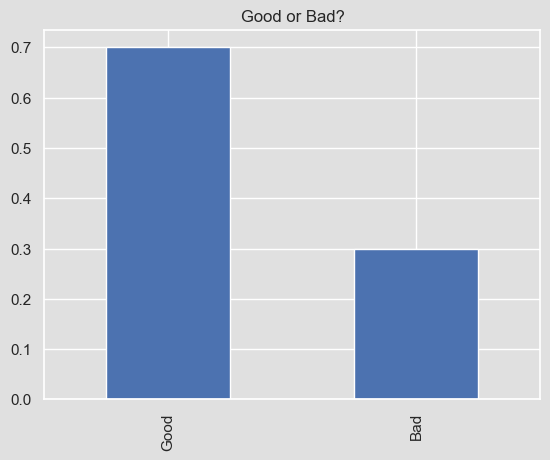

In [12]:
df["good_or_bad"].value_counts(normalize=True).plot(kind="bar")
plt.title("Good or Bad?")
plt.show()

As we can see, the dataset is mildly unbalanced (70/30%).

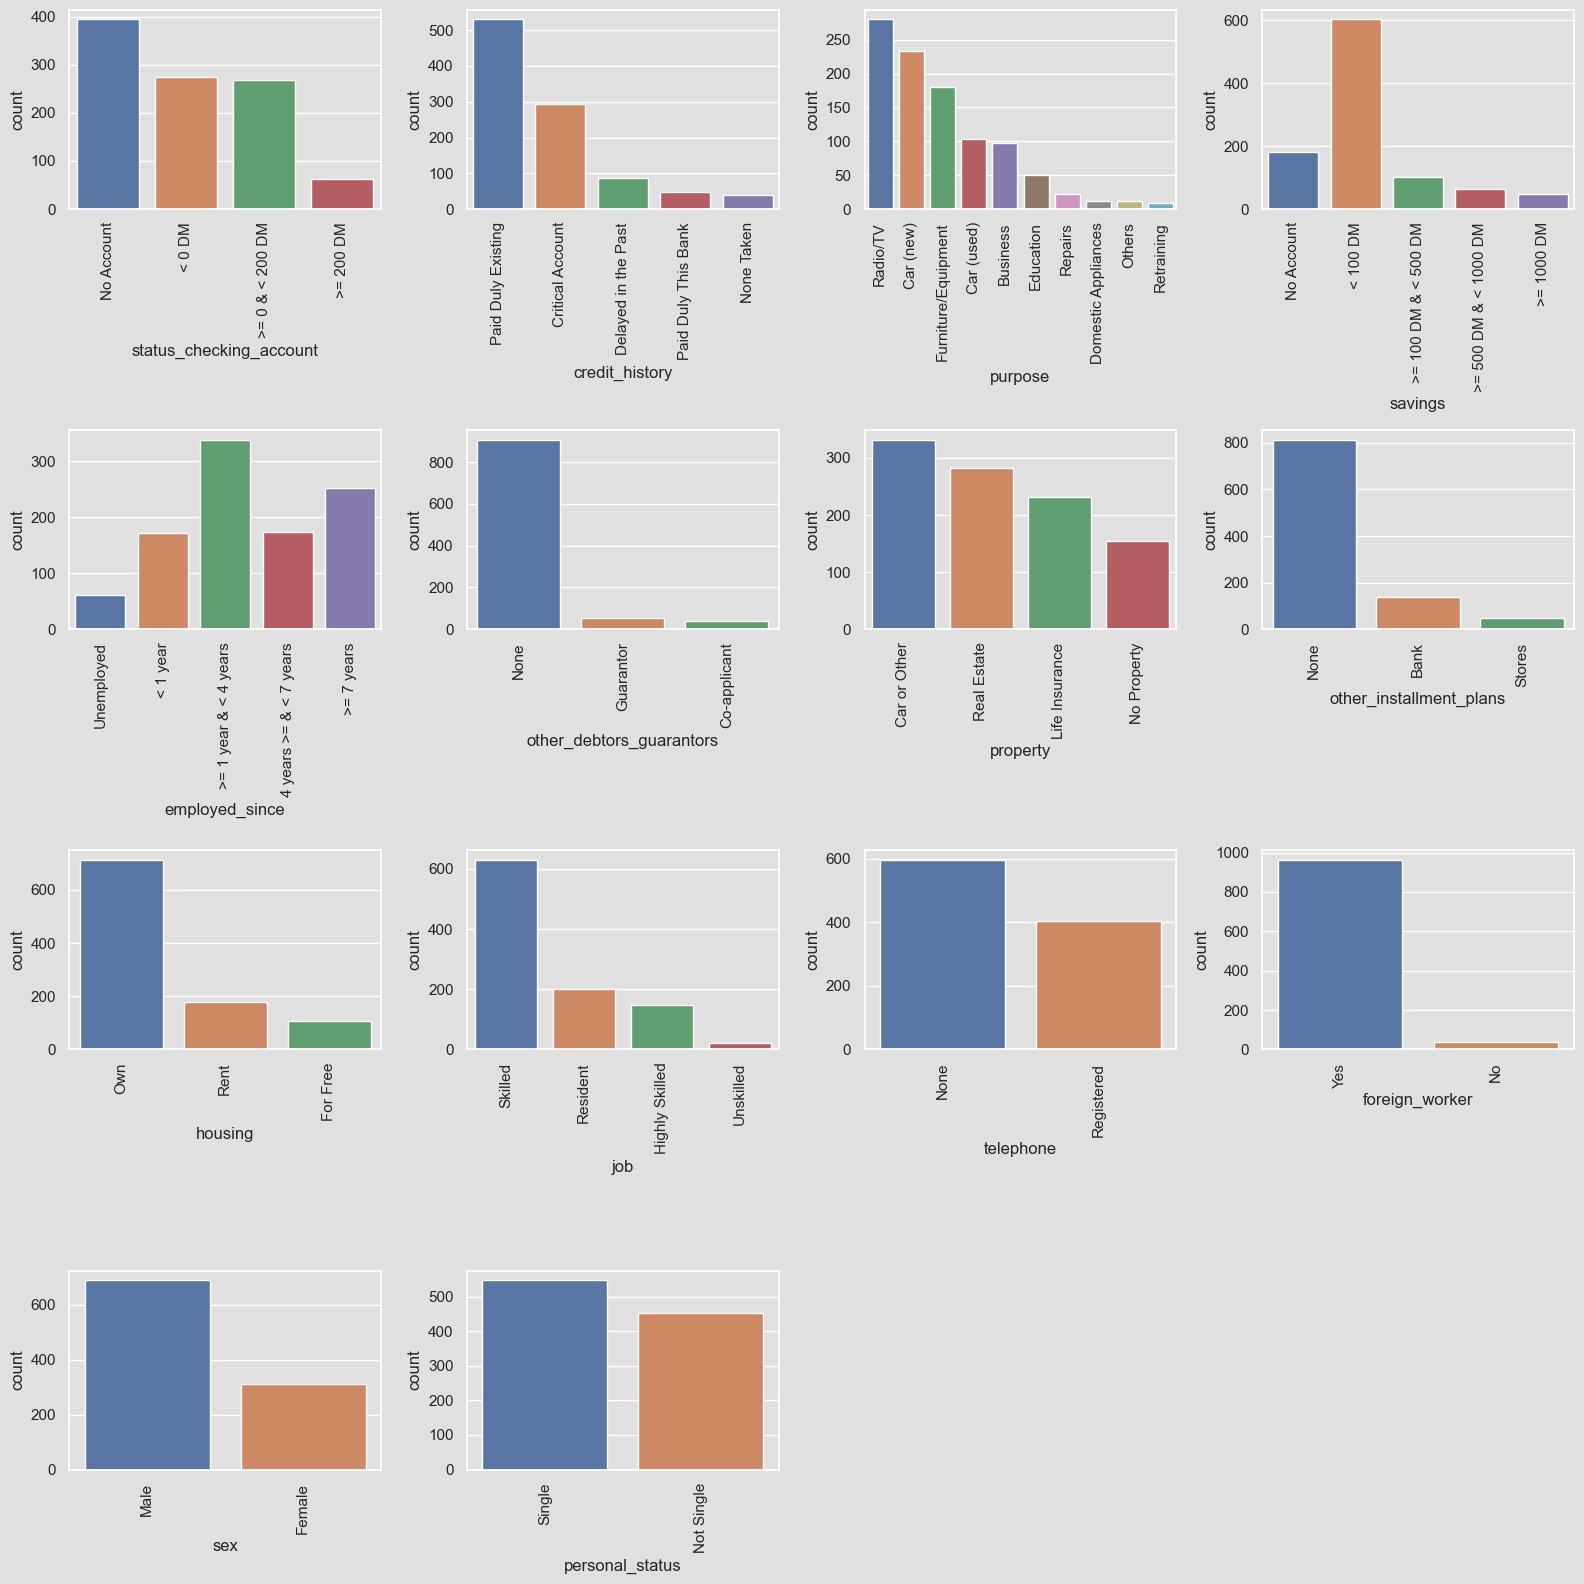

In [13]:
categorical = [col for col in df.columns if not is_numeric_dtype(df[col]) and col is not "good_or_bad"]
n_cols = 4
n_rows = math.ceil(len(categorical) / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, n_rows * 4))

i = 0
while i < (n_rows * n_cols):
    ax = axes[i // n_cols][i % n_cols]

    if i >= len(categorical):
        ax.remove()
        i += 1
        continue
    
    col = categorical[i]

    if is_categorical_dtype(df[col]):
        sns.countplot(data=df, x=col, ax=ax)
    else:
        counts = df[col].value_counts().sort_values(ascending=False)
        sns.barplot(x=counts.index.values, y=counts, ax=ax)
        ax.set_xlabel(col)
        ax.set_ylabel("count")

    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

    i += 1

fig.tight_layout()
plt.show()

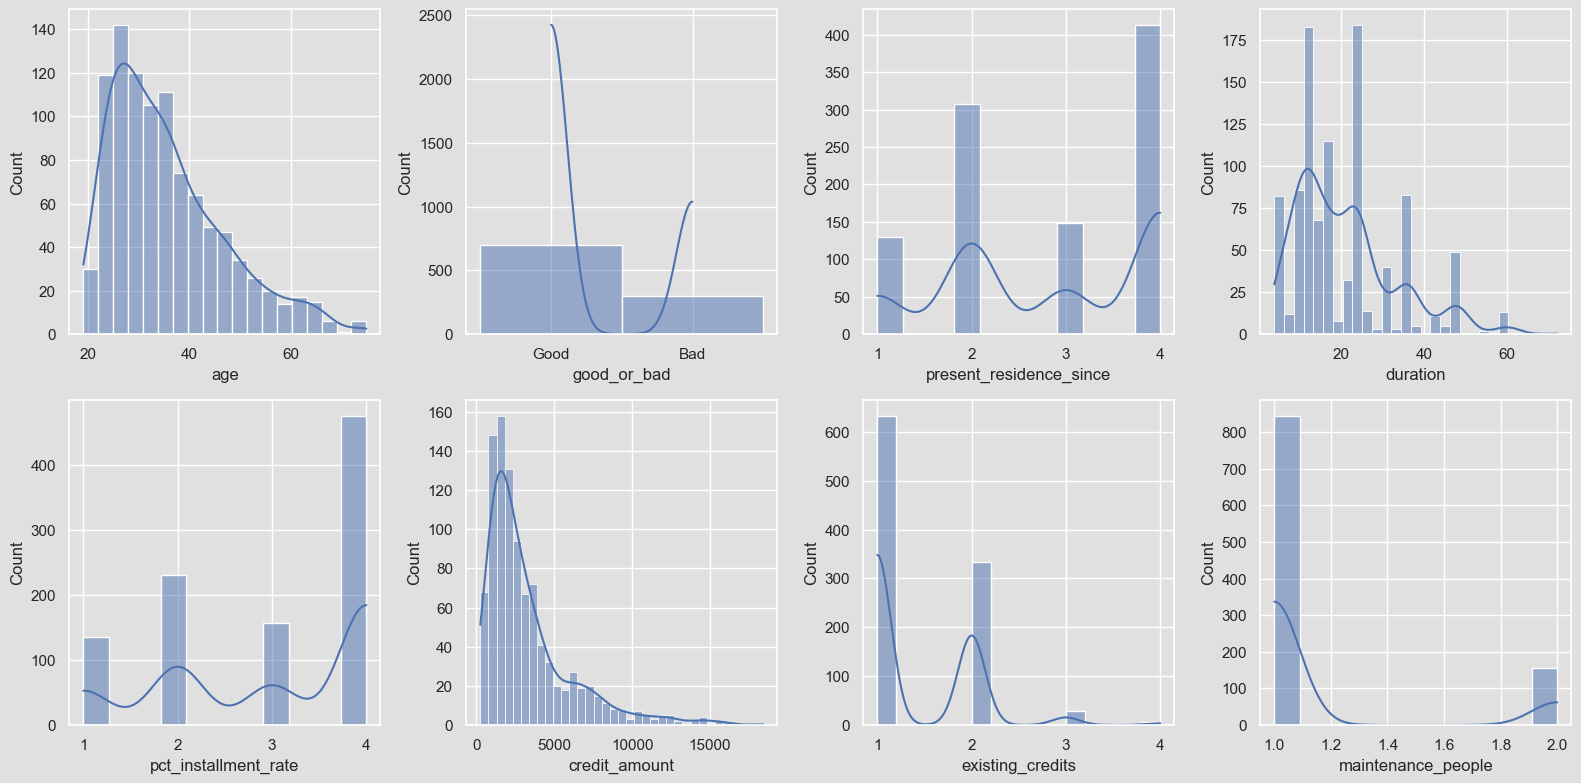

In [14]:
numerical = list(set(df.columns.values) - set(categorical))
n_cols = 4
n_rows = math.ceil(len(numerical) / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, n_rows * 4))

i = 0
while i < (n_rows * n_cols):
    ax = axes[i // n_cols][i % n_cols]

    if i >= len(numerical):
        ax.remove()
        i += 1
        continue
    
    col = numerical[i]
    sns.histplot(data=df, x=col, kde=True, ax=ax)

    i += 1

fig.tight_layout()
plt.show()

## <a id="classification"></a>Classification

In [44]:
ordinal_encoder = OrdinalEncoder()
onehot_encoder = OneHotEncoder()
label_encoder = LabelEncoder()

enconding = ColumnTransformer([
    ("encoder", ordinal_encoder, [col for col in df.columns if not is_numeric_dtype(df[col]) and col is not "good_or_bad"])
], remainder="passthrough")

clfs = [
    lightgbm.LGBMClassifier(random_state=42, max_depth=4, n_estimators=1000),
    RandomForestClassifier(random_state=42, max_depth=4, n_estimators=2000, class_weight={0: 1, 1: 0.7})
]

X = df.drop("good_or_bad", axis=1)
y = label_encoder.fit_transform(df["good_or_bad"])

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

for clf in clfs:
    pipe = Pipeline([
        ("encoding", enconding),
        ("classifier", clf)
    ])

    pipe.fit(X_train, y_train)
    preds = pipe.predict(X_test)
    accuracy = accuracy_score(y_test, preds)
    recall = recall_score(y_test, preds)

    print(f"Accuracy: {accuracy}\nRecall: {recall}")

Accuracy: 0.76
Recall: 0.8428571428571429
Accuracy: 0.78
Recall: 0.9214285714285714
